# The requirements

The current implementation is mostly inspired by the github repository, 
[SRCNN-keras](https://github.com/MarkPrecursor/SRCNN-keras)

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# check package versions
import sys
import torch
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('torch: {}'.format(torch.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
torch: 1.10.0+cu111
OpenCV: 4.1.2
NumPy: 1.19.5
Matplotlib: 3.2.2
Scikit-Image: 0.18.3


In [4]:
# import the necessary packages
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from __future__ import print_function, division
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils, models
from torchsummary import summary
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np
import math
import os
from PIL import Image
import h5py

# python magic function, displays pyplot figures in the notebook
%matplotlib inline

# Data Preprocessing

In [5]:
# check the format of the images
sample = cv2.imread('/content/drive/MyDrive/DIV2K/DIV2K_train_HR/0001.png')
img = Image.fromarray(sample)
print('The images are in the "{}" format'.format(img.mode))

The images are in the "RGB" format


## Give the paths of images in your local machine

In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# these paths are not used to run the notebook because they all were once used to create the patches 
# so, the patches is already produced and stored as ".h5" files (see section 3.1)
train_path_dataX2bic = r'DIV2K/DIV2K_train_LR_bicubic/X2/'
train_path_dataX3bic = r'DIV2K/DIV2K_train_LR_bicubic/X3/'
train_path_dataX4bic = r'DIV2K/DIV2K_train_LR_bicubic/X4/'
train_path_dataX2un = r'DIV2K/DIV2K_train_LR_unknown/X2/'
train_path_dataX3un = r'DIV2K/DIV2K_train_LR_unknown/X3/'
train_path_dataX4un = r'DIV2K/DIV2K_train_LR_unknown/X4/'
train_path_label = r'DIV2K/DIV2K_train_HR/'

valid_path_dataX2bic = r'DIV2K/DIV2K_valid_LR_bicubic/X2/'
valid_path_dataX3bic = r'DIV2K/DIV2K_valid_LR_bicubic/X3/'
valid_path_dataX4bic = r'DIV2K/DIV2K_valid_LR_bicubic/X4/'
valid_path_dataX2un = r'DIV2K/DIV2K_valid_LR_unknown/X2/'
valid_path_dataX3un = r'DIV2K/DIV2K_valid_LR_unknown/X3/'
valid_path_dataX4un = r'DIV2K/DIV2K_valid_LR_unknown/X4/'
valid_path_label = r'DIV2K/DIV2K_valid_HR/'

## Define the functions to be used in preprocessing the images

### the function "prepare_data" is used to create some random patches of an image that is used for fine tuning the parameters. For each image, the function produces 30 random patches with the size of 32 x 32 and 20 x 20 for the data and its corresponding labels. we crop the label because in the network, the input image is reduced in shape (see section 4)

In [6]:
# optional parameters
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6   # = (f1 + f2 + f3 - 3) // 2 = 6
scale = 2


def prepare_data(path_data, path_label):
    
    name_data = os.listdir(path_data)
    name_label = os.listdir(path_label)
    name_data = sorted(name_data)
    name_label = sorted(name_label)
    nums = name_data.__len__()
    
    # arrays used to save the patches of training image used for fine tuning the parameters
    data = np.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=np.double)
    label = np.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=np.double)

    for i in range(nums):
        # read the high-res image and the corresponding low-res one
        name_hr = path_label + name_label[i]
        name_lr = path_data + name_data[i]
        hr_img = cv2.imread(name_hr, cv2.IMREAD_COLOR)
        lr_img = cv2.imread(name_lr, cv2.IMREAD_COLOR)
        shape_hr = hr_img.shape
        shape_lr = lr_img.shape
        
        # convert BGR to YCrCb and take the Y channel
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2YCrCb)
        lr_img = lr_img[:, :, 0]

        # resize the low-res image to the corresponding high-res one
        lr_img = cv2.resize(lr_img, (shape_hr[1], shape_hr[0]), interpolation=cv2.INTER_CUBIC)

        # produce Random_Crop random coordinate to crop training image
        Points_x = np.random.randint(0, min(shape_hr[0], shape_hr[1]) - Patch_size, Random_Crop)
        Points_y = np.random.randint(0, min(shape_hr[0], shape_hr[1]) - Patch_size, Random_Crop)

        # produce, normalize ,and store the patches
        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

    return data, label


### the function "prepare_crop_data" is used to create patches of every image that is used to train the network from scratch. The number of patches created for each image depends on the size of the image and the hyper parameters, block_step and block_size

In [7]:
BLOCK_STEP = 16
BLOCK_SIZE = 32


def prepare_crop_data(path_data, path_label):
    
    name_data = os.listdir(path_data)
    name_label = os.listdir(path_label)
    name_data = sorted(name_data)
    name_label = sorted(name_label)
    nums = name_data.__len__()
    
    # lists to save the patches for training the network
    data = []
    label = []

    for i in range(nums):

        # read the high-res image and the corresponding low-res one
        name_hr = path_label + name_label[i]
        name_lr = path_data + name_data[i]
        hr_img = cv2.imread(name_hr, cv2.IMREAD_COLOR)
        lr_img = cv2.imread(name_lr, cv2.IMREAD_COLOR)
        shape_hr = hr_img.shape
        shape_lr = lr_img.shape

        # convert BGR to YCrCb and take the Y channel
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2YCrCb)
        lr_img = lr_img[:, :, 0]
        
        # resize the low-res image to the corresponding high-res one
        lr_img = cv2.resize(lr_img, (shape_hr[1], shape_hr[0]), interpolation=cv2.INTER_CUBIC)
        
        height_num = (shape_hr[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        width_num  = (shape_hr[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        
        # produce, normalize ,and store the patches
        for k in range(height_num):
            for j in range(width_num):   
                h = k * BLOCK_STEP
                w = j * BLOCK_STEP

                hr_patch = hr_img[h: h + BLOCK_SIZE, w: w + BLOCK_SIZE]
                lr_patch = lr_img[h: h + BLOCK_SIZE, w: w + BLOCK_SIZE]
                
                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = np.zeros((1, Patch_size, Patch_size), dtype=np.double)
                hr = np.zeros((1, label_size, label_size), dtype=np.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = np.array(data, dtype=float)
    label = np.array(label, dtype=float)
    
    return data, label

## store the data/patches and read them

In [8]:
# This function is used to save image data patches and their label patches to hdf5 file
# "output_filename.h5" contains data and label
def write_hdf5(data, labels, output_filename):

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()

# read the h5 data 
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        return data, label

# Build Dataset

To train the model from scratch, the function "prepare_crop_data" from the section 2.2.2 should be used which returns two arrays, data including arrays with the shape 32 x 32, and label including arrays with the shape 20 x 20

To tune the model, the function "prepare_data" from the section 2.2.1 should be used which returns two arrays, data including arrays with the shape 32 x 32, and label including arrays with the shape 20 x 20. This function produces 30 random patches for each image

## Create Patches 
Using "prepare_data" function, we produce 30 random patches for each image of train and validation data (800 images for train and 100 images for validation). Finally, for the training, we have an array with the shape (24000, 1, 32, 32) for data and an array with the shape (24000, 1, 20, 20) for labels, and for the validation an array with the shape (3000, 1, 32, 32) for data and an array with the shape (3000, 1, 20, 20) for labels

Uncomment the line for which you want to create patches and then put the corresponding names in the cell related to save patches using "write_hdf5" function

In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this is not used to run the notebook because they all were once executed
# data patches and all corresponding label patches are stored as ".h5" file in 
# a folder called h5

# create patches for data and labels for fine tuning (TRAIN_BICUBIC_X2, X3, and X4)
data_tune_X2bic, label_tune = prepare_data(train_path_dataX2bic, train_path_label)
# data_tune_X3bic, label_tune = prepare_data(train_path_dataX3bic, train_path_label)
# data_tune_X4bic, label_tune = prepare_data(train_path_dataX4bic, train_path_label)

# create patches for data and labels for fine tuning (TRAIN_UNKNOWN_X2, X3, and X4)
# data_tune_X2un, label_tune = prepare_data(train_path_dataX2un, train_path_label)
# data_tune_X3un, label_tune = prepare_data(train_path_dataX3un, train_path_label)
# data_tune_X4un, label_tune = prepare_data(train_path_dataX4un, train_path_label)

# create patches for data and labels for validation (VALID_BICUBIC_X2, X3, X4)
data_val_X2bic, label_val = prepare_data(valid_path_dataX2bic, valid_path_label) 
# data_val_X3bic, label_val = prepare_data(valid_path_dataX3bic, valid_path_label) 
# data_val_X4bic, label_val = prepare_data(valid_path_dataX4bic, valid_path_label)

# create patches for data and labels for validation (VALID_UNKNOWN_X2, X3, X4)
# data_val_X2un, label_val = prepare_data(valid_path_dataX2un, valid_path_label) 
# data_val_X3un, label_val = prepare_data(valid_path_dataX3un, valid_path_label) 
# data_val_X4un, label_val = prepare_data(valid_path_dataX4un, valid_path_label)

In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook
# save the data and the corresponding labels as a ".h5" file using the function "write_hdf5" 
# Note that you should make a folder named "h5" in the current working directory
write_hdf5(data_tune_X2bic, label_tune, r'h5/X2_BICUBIC_TRAIN.h5')
write_hdf5(data_val_X2bic, label_val, r'h5/X2_BICUBIC_VALID.h5')

## Create Datasets

In [9]:
# create a dataset class
class Dataset_SRCNN(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform: 
            x = self.transform(x)    
            y = self.transform(y)
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# create dataset and dataloader objects for training
# read the "h5" files for each data you saved in the section 3.1 using read_training_data function
# then create Dataset object and the corresponding dataloader
d_train, l_train = read_training_data('/content/drive/MyDrive/DIV2K/h5/X2_BICUBIC_TRAIN.h5')
d_train, l_train = torch.tensor(d_train), torch.tensor(l_train)
dataset_tune = Dataset_SRCNN(d_train, l_train)
loader_tune = DataLoader(
    dataset_tune,
    batch_size=128,
    num_workers=2,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

# create dataset and dataloader objects for validation
d_val, l_val = read_training_data('/content/drive/MyDrive/DIV2K/h5/X2_BICUBIC_VALID.h5')
d_val, l_val = torch.tensor(d_val), torch.tensor(l_val)
dataset_val = Dataset_SRCNN(d_val, l_val)
loader_val = DataLoader(
    dataset_val,
    batch_size=256,
    num_workers=2,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

'dataset_eval = Dataset_SRCNN(data_eval_X2bic, label_eval)\nloader_eval = DataLoader(\n    dataset_eval,\n    batch_size=256,\n    num_workers=2,\n    shuffle=True,\n    pin_memory=torch.cuda.is_available()\n)'

# Build the network (SRCNN)

It is based on the network presented in the paper [Learning a Deep Convolutional Network for Image Super-Resolution](https://link.springer.com/chapter/10.1007/978-3-319-10593-2_13)

In [10]:
# create a network class 
class SRCNN(nn.Module):
    
    def __init__(self, f1=9, f2=3, f3=5, n1=128, n2=64, c=1, mode=None, input_size=None):
        super().__init__()
        assert mode in ['train', 'tune', 'test'], 'mode parameter must be "train", "tune", or "test"'
        if mode in ['train', 'tune'] and input_size != 32:
            raise Exception("the input size should be 32 while in train/tune mode")
        self.feature = nn.Conv2d(c, n1, f1)  # (1, 32, 32) ==> (128, 24, 24)        
        self.remap = nn.Conv2d(n1, n2, f2, padding='same')   # (128, 24, 24) ==> (64, 24, 24)
        self.reconstruct = nn.Conv2d(n2, c, f3)  # (64, 24, 24) ==> (1, 20, 20)

    # Input: N, C, H, W
    # Output: N, C, H-12, W-12
    def forward(self, x):
        x = self.feature(x)
        x = torch.nn.functional.relu(x, inplace=True)
        x = self.remap(x)
        x = torch.nn.functional.relu(x, inplace=True)
        x = self.reconstruct(x)
        return x

# Train/Tune and evaluate the model
In this section, we tune the pretrained model parameters called "SRCNN_keras_weight.h5"

For this project, it was not practical to train the model from scratch because of two reasons: 1) we have 900 images (800 train images and 100 validation images) for 2 degradation operators and 3 downscale factors, so there are large number of high-resolution images which leads to have a huge amount of patches, 2) it takes a few days to train the network  

In [11]:
# set the device
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# set the required arguments for "train_tune" function
dataloader_train = loader_tune
dataloader_valid = loader_val
model = SRCNN(f1=9, f2=3, f3=5, n1=128, n2=64, c=1, mode='tune', input_size=32)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()
nb_epochs_tune = 20

In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# print model
summary(model.to(device),(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 24, 24]          10,496
            Conv2d-2           [-1, 64, 24, 24]          73,792
            Conv2d-3            [-1, 1, 20, 20]           1,601
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.85
Params size (MB): 0.33
Estimated Total Size (MB): 1.18
----------------------------------------------------------------


In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# read the pretrained tf weights and layer names
def read_tf_weights(path):
    weights = {}
    keys = []
    with h5py.File(path, 'r') as f: 
        f.visit(keys.append) 
        for key in keys:
            if ':' in key:
                print(f[key].name)
                weights[f[key].name] = f[key][()]
    return weights

tf_original_weights = read_tf_weights('/content/drive/MyDrive/DIV2K/SRCNN_keras_weight.h5')

In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# load improved model parameters
torch_weights = torch.load('/content/drive/MyDrive/DIV2K/improved models/params_after_training_X2_BICUBIC.h5')
model.load_state_dict(torch_weights)

<All keys matched successfully>

In [ ]:
'''
DO NOT RUN THIS. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# determine the torch layer names
name_layers = model.named_modules()
lst_nameLayers = list(name_layers)
print('Name of the torch layers:', [lst_nameLayers[i][0] for i in range(1,4)])

Name of the torch layers: ['feature', 'remap', 'reconstruct']


In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# the shape of weights in keras and torch are transposed, so we should transpose tf weights to load in pytorch model
model.feature.weight.data = torch.from_numpy(np.transpose(tf_original_weights['/convolution2d_1/convolution2d_1_W:0']))
model.feature.bias.data = torch.from_numpy(np.transpose(tf_original_weights['/convolution2d_1/convolution2d_1_b:0']))
model.remap.weight.data = torch.from_numpy(np.transpose(tf_original_weights['/convolution2d_2/convolution2d_2_W:0']))
model.remap.bias.data = torch.from_numpy(np.transpose(tf_original_weights['/convolution2d_2/convolution2d_2_b:0']))
model.reconstruct.weight.data = torch.from_numpy(np.transpose(tf_original_weights['/convolution2d_3/convolution2d_3_W:0']))
model.reconstruct.bias.data = torch.from_numpy(np.transpose(tf_original_weights['/convolution2d_3/convolution2d_3_b:0']))

In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# training/tuning phase
# select a proper name for the second argument of the command in the line 82 
# This name should be related with the current dataset used for training/tuning
def train_tune(dataloader_train, dataloader_valid, model, optimizer, criterion, nb_epochs):
    
    # move the model to device (GPU or CPU)
    model.to(device)
    
    # store loss of each epoch for train and validation
    loss_train = []
    loss_valid = []
    
    # print the header of the result table
    print('Start training...\n')
    print(f"{'Epoch':^7} | {'Avg. Train Loss':^12} | {'Avg. Valid Loss':^12} | {'Elapsed':^9} ")
    print("-"*70)
    
    for i_epoch in range(nb_epochs):
        
        # measure the elapsed time of each epoch
        t0_epoch = time.time()
        
        # reset tracking variables at the beginning of each epoch
        total_loss = 0
        
        # put the model into the training mode
        model.train()
        
        # batch for loop (step = index of each batch)
        for step, batch in enumerate(dataloader_train):
            
            # load batch to device (GPU or CPU)
            X_batch, y_batch = tuple(t.to(device) for t in batch)

            # zero out any previously calculated gradients
            model.zero_grad()
            
            # perform a forward pass. This will return the reconstructed patch
            rec_batch = model(X_batch)
            
            # compute loss and accumulate the loss values
            loss = criterion(rec_batch, y_batch)
            total_loss += loss.item()
                
            # perform a backward pass to calculate gradients
            loss.backward()

            # update parameters and the learning rate
            optimizer.step()
            
        # Calculate the average loss of each epoch for train
        avg_train_loss = total_loss / (step + 1)
        loss_train.append(avg_train_loss)
        
        # put the model into the valiadtion mode
        model.eval()
        total_loss = 0
        with torch.no_grad(): 
            for step, batch in enumerate(dataloader_valid):
                
                # load batch to device (GPU or CPU)
                X_batch, y_batch = tuple(t.to(device) for t in batch)
                
                rec_batch = model(X_batch)
                
                # compute and store loss
                loss = criterion(rec_batch, y_batch)
                total_loss += loss.item()
                
                # Calculate the average loss of each epoch for validation
            avg_valid_loss = total_loss / (step + 1)
            loss_valid.append(avg_valid_loss)
                
        # Calculate time elapsed for the current epoch
        time_elapsed = time.time() - t0_epoch
        
        # Print the current results
        print(f"{i_epoch + 1:^7} | {avg_train_loss:^12.6f} | {avg_valid_loss:^12.6f} | {time_elapsed:^9.2f}")
                 
    # save the parameters of the current trained/tuned model
    torch.save(model.state_dict(), 'params_after_training_X2_BICUBIC.h5')
    
    return loss_train, loss_valid

avgLosses_train, avgLosses_valid = train_tune(dataloader_train, dataloader_valid, model, optimizer, criterion, nb_epochs_tune)
print('\nTraining/Tuning completes')

Start training...

 Epoch  | Avg. Train Loss | Avg. Valid Loss |  Elapsed  
----------------------------------------------------------------------
   1    |   0.001298   |   0.001085   |   4.41   
   2    |   0.001097   |   0.001017   |   4.31   
   3    |   0.001061   |   0.001004   |   4.34   
   4    |   0.001044   |   0.000980   |   4.35   
   5    |   0.001031   |   0.000970   |   4.38   
   6    |   0.001021   |   0.000964   |   4.40   
   7    |   0.001015   |   0.000957   |   4.43   
   8    |   0.001005   |   0.000955   |   4.43   
   9    |   0.001003   |   0.000947   |   4.45   
  10    |   0.000995   |   0.000941   |   4.46   
  11    |   0.000993   |   0.000946   |   4.49   
  12    |   0.000988   |   0.000942   |   4.48   
  13    |   0.000984   |   0.000955   |   4.47   
  14    |   0.000981   |   0.000931   |   4.44   
  15    |   0.000981   |   0.000929   |   4.43   
  16    |   0.000975   |   0.000928   |   4.40   
  17    |   0.000974   |   0.000923   |   4.38   
  1

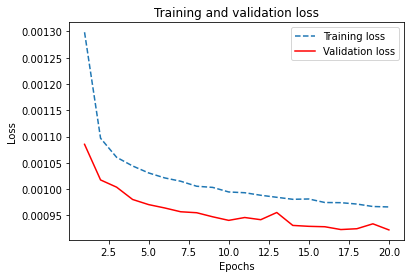

In [ ]:
'''
DO NOT RUN THIS CELL. READ COMMENTS FIRST
'''
# this cell is not used to run the notebook unless you want to run a new fine tuning
# compare the training and validation losses
def plot_losses(train_loss, val_loss):

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, '--', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(avgLosses_train, avgLosses_valid)

# Test the model

In [12]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):    
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten()

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define a function for mean squared error (MSE)
def mse(target, ref):
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    # divide err by the shape of the image to get the error per pixel
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define a function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    # multichannel is True: treat the last dimension of the array as channels
    scores.append(ssim(target, ref, multichannel=True))
    
    return scores

## Reconstruct degraded image(s) outside the training/validation images

In [13]:
# define a function to make sure that the image is divisible by arbitrary scale
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

# define a function to remove the first and last pixels after convolutions
def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [14]:
# this function takes path of HR images for test, the interpolation method, and the scale used for degradation
# the function produced the degraded images and returns the path of the folder containing them which is like:
# test/LR Images
# the high-res test images should be saved in a directory like: "test/HR Images/"

def degradation(hr_path, interpolation_method, scale):
    
    # get the HR image names
    names = os.listdir(hr_path)

    for img in names:
        
        # read the high-res image and convert BGR to YCrCb and take the Y channel
        # use modcrop function to be sure that the image is divisible by the scale
        hr_img = cv2.imread('/content/drive/MyDrive/DIV2K/test/HR Images/' + img)
        hr_img = modcrop(hr_img, scale)
        hr_img_conv = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img_Y = hr_img_conv[:, :, 0]
        
        h, w = hr_img_Y.shape
        
        # resize the high-res image to create a low-res one
        lr_img = cv2.resize(hr_img_Y, (w//scale, h//scale), interpolation=interpolation_method)
        lr_img = cv2.resize(lr_img, (w, h), interpolation=interpolation_method)
        
        # save the degraded image
        hr_img_conv[:, :, 0] = lr_img
        low_img = cv2.cvtColor(hr_img_conv, cv2.COLOR_YCrCb2BGR)
        
        if not os.path.isdir('/content/drive/MyDrive/DIV2K/test/LR Images'):
            add = '/content/drive/MyDrive/DIV2K/test/LR Images'
            os.makedirs(add)
        else:
            add = '/content/drive/MyDrive/DIV2K/test/LR Images'
        cv2.imwrite(add +'/'+ img, low_img)
        
    return add
    

In [15]:
# set the required arguments for test function
model = SRCNN(f1=9, f2=3, f3=5, n1=128, n2=64, c=1, mode='test')
path_images_HR = '/content/drive/MyDrive/DIV2K/test/HR Images'
path_params = '/content/drive/MyDrive/DIV2K/improved models/params_after_training_X2_BICUBIC.h5' # this should be the last weight saved on line 82 of the cell containing train_tune function

In [16]:
# test the trained/tuned model
# the original images to be used for test should be stored in a directory like: "test/HR Images/"
# so, please make the directory, "test/HR Images/"
# and the corresponding low-res ones will be saved in "test/LR Images/" using the function degradation
# the reconstructed images using the network will be saved in "test/Reconstructed Images/"
# Note that you don't need to make "test/LR Images/" and "test/Reconstructed Images/" directories, 
# If they are not available, the program makes them

def test(model, imageFolder_path, params_path, interpolation_method, scale):
    
    # restore the trained/tuned model parameters
    model.load_state_dict(torch.load(params_path))
    
    # move the model to device (GPU or CPU)
    model.to(device)
    
    # put the model into the evaluation mode
    model.eval()
    
    # get the degraded and reference images
    hr_imageNames = os.listdir(imageFolder_path)
    lr_imageNames = os.listdir(degradation(imageFolder_path,interpolation_method , scale))
    
    scores_deg_ref = []
    scores_recon_ref = []
    for i in range(len(hr_imageNames)):
        
        # read the high and low res images
        degraded = cv2.imread('/content/drive/MyDrive/DIV2K/test/LR Images/' + lr_imageNames[i])
        ref = cv2.imread('/content/drive/MyDrive/DIV2K/test/HR Images/' + hr_imageNames[i])
    
        # crop the reference image using modcrop function because the low-res image is cropped as well
        # when suing degradation function
        ref = modcrop(ref, scale)
    
        # convert the image to YCrCb - (srcnn trained on Y channel)
        temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
        # create image slice and normalize  
        Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
        Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
        
        with torch.no_grad():
            # perform super-resolution with srcnn
            Y_tensor=torch.tensor(Y,dtype=torch.float32,device=device)
            Y_tensor = Y_tensor.resize(1,1,temp.shape[0],temp.shape[1])
            pre = model(Y_tensor)
    
        # post-process output
        pre *= 255
        torch.clamp(pre, 0, 255)
        pre = pre.type(torch.uint8)
        pre_arr = pre.cpu().numpy()
    
        # copy Y channel back to image and convert to BGR
        temp = shave(temp, 6)
        temp[:, :, 0] = pre_arr[0, 0, :, :]
        output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
        
        # save the reconstructed image to "test/Reconstructed Images"
        if not os.path.isdir('/content/drive/MyDrive/DIV2K/test/Reconstructed Images'):
            add = '/content/drive/MyDrive/DIV2K/test/Reconstructed Images'
            os.makedirs(add)
        else:
            add = '/content/drive/MyDrive/DIV2K/test/Reconstructed Images'

        cv2.imwrite(add + '/' + hr_imageNames[i], output)
    
        # remove border from reference and degraged image
        ref = shave(ref.astype(np.uint8), 6)
        degraded = shave(degraded.astype(np.uint8), 6)
    
        # image quality calculations
        # scores of degraded and ref images is a list of lists: scores_deg_ref = [[psnr, mse, ssim(degraded, ref)], ...]
        # scores of reconstructed and ref images is a list of lists: scores_deg_ref = [[psnr, mse, ssim(reconstruct, ref)], ...]
        scores_deg_ref.append(compare_images(degraded, ref))
        scores_recon_ref.append(compare_images(output, ref))
    
    # return images and scores
    return scores_deg_ref, scores_recon_ref

## Compare the original, degraded, and reconstructed images

In [1]:
# for the high-res images in the "test/HR Images", test the super resolution model
# the comparisons are saved in the directory "test/results", if not available, the program creates that path
    
# perform super-resolution
scores_deg_ref, scores_recon_ref = test(model, path_images_HR, path_params, cv2.INTER_LINEAR, 2)

# get the original, degraded, and reconstructed image paths
ref = os.listdir('/content/drive/MyDrive/DIV2K/test/HR Images')
deg = os.listdir('/content/drive/MyDrive/DIV2K/test/LR Images')
rec = os.listdir('/content/drive/MyDrive/DIV2K/test/Reconstructed Images')

# display images as subplots
for i in range(len(ref)):
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    im_ref = cv2.imread('/content/drive/MyDrive/DIV2K/test/HR Images/' + ref[i])
    axs[0].imshow(cv2.cvtColor(im_ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    im_deg = cv2.imread('/content/drive/MyDrive/DIV2K/test/LR Images/' + deg[i])
    axs[1].imshow(cv2.cvtColor(im_deg, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores_deg_ref[i][0],
                                                       scores_deg_ref[i][1], scores_deg_ref[i][2]))
    im_rec = cv2.imread('/content/drive/MyDrive/DIV2K/test/Reconstructed Images/' + rec[i])
    axs[2].imshow(cv2.cvtColor(im_rec, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores_recon_ref[i][0],
                                                        scores_recon_ref[i][1], scores_recon_ref[i][2]))
    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    # save the comparing images in "test/results/"
    if not os.path.isdir('/content/drive/MyDrive/DIV2K/test/results'):
        add = '/content/drive/MyDrive/DIV2K/test/results'
        os.makedirs(add)
    else:
        add = '/content/drive/MyDrive/DIV2K/test/results'

    fig.savefig('/content/drive/MyDrive/DIV2K/test/results/{}.png'.format(os.path.splitext(ref[i])[0])) 
    plt.close()